# Capstone Project - Real Estate Development
### Applied Data Science Capstone by IBM/Coursera
### Marcos Geraldo

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Results](#results)
* [5. Discussion](#discussion)
* [6. Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

This project will provide insights about capital gain on real estate investemnts. 

It wil be targeted to landlords who are evaluating the impact of home improvements projects in the selling price of their properties.

It will also provide a model to estimate the listing price that fits the market valuation of a particular house. 

It will use current data published for the city of interest, and use it to stablish the relative weights of the key elements that drive the price of a house. 

It will use Foursquare Data to evaluate the distance to relevant venues, and evaluate the weight of those elements in the listing price of a property.



## 2. Data <a name="data"></a>

According to the problem definition, the relevant data to understand price valuation, are the following:
* selling price 
* listing price (as a proxy for selling price, that might not be public) 
* number and distance of venues 

To avoid market variations the data will come from current market conditions. The candidates are real state web sites that publish and share freely properties and listing prices:

* [Realtor](#Realtor)
* [FourSquare](#Foursquare)

The values
* Year of construction 
* Constructed suface 
* Bedrooms
* Bathrooms
* Garages
* Stories
* School ratings 
* Number of venues by category
* Distance to venues
* others to be found



### 2.1 Realtor.com <a name="Realtor"></a>

After trying some APIs, I will use Realtor as the main source for data collection, due to its reliability, and simplicity. 

Realtor offers multiple API:
* [list-for-sale](#list-for-sale)
* [detail](#detail)
* [list-sold](#list-sold)
* list-similar-homes
* list-for-rent
* list-by-mls
* list-similar-rental-homes


#### 2.1.1 list-for-sale API<a name="list-for-sale"></a>

This API shows properties for sale inin groups of 200. 
Here is an example of how I read two pages using the variable Offset:


In [3]:
import requests
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize


In [4]:
city_nm = 'Pleasanton'
address_st = '942 Clinton Pl'
state_cd = 'CA'
rapid_key = pd.read_csv('Realtor API rapid key').set_index('API_provider').at['Realtor','key']

In [3]:
limit = 200
page = 0 
url = "https://realtor.p.rapidapi.com/properties/v2/list-for-sale"
querystring = {"sort":"relevance","city":city_nm,"limit":limit,"offset":page*limit,"state_code":state_cd}
headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': rapid_key
    }
response = requests.request("GET", url, headers=headers, params=querystring)

In [4]:
df = json_normalize(response.json()['properties'])

In [5]:
df.shape

(200, 94)

In [6]:
df.head()

,address.city,address.county,address.fips_code,address.is_approximate,address.lat,address.line,address.lon,address.neighborhood_name,address.postal_code,address.state,...,plan_id,price,prop_status,prop_sub_type,prop_type,property_id,rank,rdc_web_url,thumbnail,virtual_tour.href
0,Pleasanton,Alameda,06001,NaN,37.691203,4421 Comanche Way,-121.878980,NaN,94588,California,...,NaN,695000,for_sale,townhomes,condo,M1735190682,1,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/507c63e1d76637db36cc4558...,NaN
1,Pleasanton,Alameda,06001,NaN,37.662937,4156 Vineyard Ave,-121.868816,NaN,94566,California,...,NaN,1195000,for_sale,NaN,single_family,M2757240123,2,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/e733a051920af503c95c2443...,NaN
2,Pleasanton,Alameda,06001,NaN,37.660999,830 Sylvaner Dr,-121.847674,Vintage Hills,94566,California,...,NaN,1150000,for_sale,NaN,single_family,M1772307561,3,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/2373e75c4282f47678bade57...,NaN
3,Pleasanton,Alameda,06001,NaN,37.695073,4141 Lucca Ct,-121.892225,NaN,94588,California,...,NaN,749888,for_sale,townhomes,condo,M1381126962,4,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/0664c1d8e88e284e7f374b92...,https://4141luccacourt29006.f8re.com/Website/I...
4,Pleasanton,Alameda,06001,NaN,37.643988,862 Sunny Brook Way,-121.872693,Bridle Creek,94566,California,...,NaN,1938000,for_sale,NaN,single_family,M1108369825,5,https://www.realtor.com/realestateandhomes-det...,https://ap.rdcpix.com/3960b906c63959f1f649a8be...,https://www.tourfactory.com/2782009


To read all the data, I will need a Function to read each page of the query
Here I defined two functions:

* **read_realtor**: requests a specific page for a city. This query can get up to 200 records
* **list_for_sale**: uses *read_realtor* function to collect all the avalable pages for that city

In [7]:
def read_realtor(city_nm, state_cd, limit, page_num):
    url = "https://realtor.p.rapidapi.com/properties/v2/list-for-sale"
    querystring = {"sort":"relevance","city":city_nm,"limit":limit,"offset":page_num*limit,"state_code":state_cd}
    headers = {
        'x-rapidapi-host': "realtor.p.rapidapi.com",
        'x-rapidapi-key': rapid_key
        }
    response = requests.request("GET", url, headers=headers, params=querystring)
    df = json_normalize(response.json()['properties'])
    return df

In [8]:
def list_for_sale(city_nm, state_cd, limit, page_num):
    num_rows = 0
    df = read_realtor(city_nm, state_cd, limit, page_num)
    if df.shape[0] == limit:
        df=df.append(read_realtor(city_nm, state_cd, limit, page_num + 1), sort=True)
    df = df.reset_index()
    df = df.drop(columns=['index'])
    return df


To explore the data I will get the properties published for San Ramon

In [9]:
resp= list_for_sale('San Ramon','CA',200,0)

In [11]:
resp.shape

(222, 93)

Here is a visual representation of the proprties in currently in the city selected:

In [17]:
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
#setting colors
number_types = len(resp['beds'].unique())
colors_array = cm.rainbow(np.linspace(0, 1,number_types))
rainbow = pd.DataFrame([colors.rgb2hex(i) for i in colors_array])
rainbow.index = resp['beds'].unique()
# centring the screen:
latitude = (resp['address.lat'].max()+resp['address.lat'].min())/2
longitude = (resp['address.lon'].max()+resp['address.lon'].min())/2
# create map of Toronto using latitude and longitude values
map_tto = folium.Map(location=[latitude, longitude], zoom_start=13)
# add markers to map
for lat, lng, address, neighborhood, beds, price, size in zip(resp['address.lat'], resp['address.lon'], 
                                                              resp['address.line'], resp['address.county'],
                                                              resp['beds'],resp['price'],
                                                              resp['building_size.size']):
    label = '{}, {}, {} beds, ${}, {}sqft, ({})'.format(address, neighborhood,beds, price, size, price/size)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow.loc[beds][0],
        fill_opacity=0.7,
        parse_html=False).add_to(map_tto)  
    
map_tto

In [27]:
resp[['price','beds']].describe()

,price,beds
count,2.220000e+02,222.000000
mean,1.119525e+06,3.477477
std,4.775406e+05,1.023231
min,3.699000e+05,1.000000
25%,8.182500e+05,3.000000
50%,1.035000e+06,4.000000
75%,1.391660e+06,4.000000
max,2.890000e+06,6.000000


In [29]:
pd.DataFrame(resp['price']/ resp['building_size.size']).describe()


,0
count,222.000000
mean,507.647293
std,81.677843
min,339.422260
25%,455.102821
50%,507.006105
75%,554.360942
max,897.196262


#### 2.1.2 Detail API <a name="detail"></a>

I will have to use the details API to get details such as
* Schools raitings
* Year Built
* Number of Stories

In [224]:
url = "https://realtor.p.rapidapi.com/properties/v2/detail"

property_id = 'M2695052375'
querystring = {"property_id":property_id}
headers = {
    'x-rapidapi-host': "realtor.p.rapidapi.com",
    'x-rapidapi-key': rapid_key
    }

response = requests.request("GET", url, headers=headers, params=querystring)

In [225]:
json_normalize(response.json()['properties'][0]['schools'])

,distance_in_miles,education_levels,funding_type,grades.range.high,grades.range.low,greatschools_id,id,lat,location.city,location.city_slug_id,...,location.street,lon,name,nces_id,phone,ratings.great_schools_rating,ratings.parent_rating,relevance,student_count,student_teacher_ratio
0,0.6,[elementary],public,5,K,0600548,078579241,37.755837,San Ramon,San-Ramon_CA,...,13000 Broadmoor Drive,-121.951006,Montevideo Elementary School,063513005953,(925) 479-6100,9.0,4.0,assigned,658.0,25.9
1,0.8,[middle],public,8,6,0600549,078579251,37.738203,San Ramon,San-Ramon_CA,...,3000 Pine Valley Road,-121.942177,Pine Valley Middle School,063513005955,(925) 479-7700,9.0,4.0,assigned,1049.0,25.7
2,0.4,[high],public,12,9,0600537,078579101,37.746233,San Ramon,San-Ramon_CA,...,9870 Broadmoor Drive,-121.946474,California High School,063513005943,(925) 803-3200,9.0,4.0,assigned,2777.0,23.7
3,0.7,[elementary],public,5,K,0600534,078579041,37.740982,San Ramon,San-Ramon_CA,...,2849 Calais Drive,-121.948432,Neil A. Armstrong Elementary School,063513005954,(925) 479-1600,9.0,4.0,nearby,544.0,26.1
4,1.6,[middle],public,8,6,0600544,078579201,37.770021,San Ramon,San-Ramon_CA,...,12601 Alcosta Boulevard,-121.957406,Iron Horse Middle School,063513005729,(925) 824-2820,9.0,4.0,nearby,1069.0,25.5
5,2.5,[high],public,12,9,0617434,078820461,37.768475,San Ramon,San-Ramon_CA,...,10550 Albion Road,-121.903099,Dougherty Valley High School,063513011990,(925) 479-6400,10.0,3.0,nearby,3331.0,23.8
6,1.0,[elementary],private,6,K,0631666,079023801,37.749416,San Ramon,San-Ramon_CA,...,19001 San Ramon Valley Blvd,-121.960388,Heritage Academy - San Ramon,2ccc7444a98d6982e06b115607f16b24,(925) 558-5577,NaN,5.0,nearby,NaN,NaN
7,1.8,[elementary],private,5,PK,0610419,078720251,37.755501,San Ramon,San-Ramon_CA,...,2762 Derby Dr,-121.973801,CA Christian Academy,A9700302,(510) 381-7695,NaN,NaN,nearby,NaN,NaN


Each property has a list of schools. 
I will get the average of the raitings as the index of schools quality. 

In [226]:
school_list = json_normalize(response.json()['properties'][0]['schools'])

In [227]:
school_list['ratings.great_schools_rating'].mean()

9.166666666666666

The function **get_details** that gets those three details: 
* School rating
* Stories
* Year Built

Different kinsd of properties have different JSON structures, so this function needs to react correctly when the data is not found. 

In [228]:
def get_details(property_id):
    querystring = {"property_id":property_id}
    headers = {
        'x-rapidapi-host': "realtor.p.rapidapi.com",
        'x-rapidapi-key': rapid_key
        }
    response = requests.request("GET", url, headers=headers, params=querystring)
    # the mean school rating
    try:
        school_list = json_normalize(response.json()['properties'][0]['schools'])
    except:
        school_rating = np.nan
    else:
        school_rating = school_list['ratings.great_schools_rating'].mean()

    # stories or levels in the house
    try:
        stories = response.json()['properties'][0]['stories']
    except: 
        stories = np.nan
    else:
        stories = response.json()['properties'][0]['stories']
    
    #construction year
    try:
        year_built =  response.json()['properties'][0]['year_built']
    except:
        year_built = np.nan
    else:
        year_built =  response.json()['properties'][0]['year_built']
        
    return pd.DataFrame({'school_rating':[school_rating],'stories':[stories],'year_built':[year_built]})

In [35]:
resp_detail = get_details('M2269810031')

In [36]:
resp_detail

,school_rating,stories,year_built
0,8.0,None,1974


#### 2.1.3 the data from the two API

I will select the relevant columns from the full list of properties, and then I will use *get_details* for each property to get these three values 

In [37]:
train_data = resp[pd.notna(resp['listing_id'])][['property_id', 'listing_id',
                                                 'address.city','address.county',
                                                 'address.lat', 'address.lon',
                                                 'address.neighborhood_name','address.postal_code',
                                                 'baths_full','baths_half','beds',
                                                 'building_size.size','lot_size.size',
                                                 'prop_type','prop_status','price'
     ]]

In [42]:
train_data.shape

(203, 19)

In [39]:
for prop_id in train_data['property_id']:
    det_temp = get_details(prop_id)
    train_data.loc[resp['property_id']==prop_id, 'school_rating']=det_temp.loc[0,'school_rating']
    train_data.loc[resp['property_id']==prop_id, 'stories']=det_temp.loc[0,'stories']
    train_data.loc[resp['property_id']==prop_id, 'year_built']=det_temp.loc[0,'year_built']
                

Finally here is an initial data set to work with. 


In [44]:
train_data.tail()

,property_id,listing_id,address.city,address.county,address.lat,address.lon,address.neighborhood_name,address.postal_code,baths_full,baths_half,beds,building_size.size,lot_size.size,prop_type,prop_status,price,school_rating,stories,year_built
217,M9104371519,2913840789,San Ramon,Contra Costa,37.766450,-121.917223,NaN,94582,4,1.0,4,3161,6775.0,single_family,for_sale,1699995,8.166667,2.0,2020.0
218,M9154671243,2913839368,San Ramon,NaN,37.766450,-121.917223,NaN,94582,4,NaN,4,3737,4076.0,single_family,for_sale,1546000,8.166667,3.0,2020.0
219,M1998497830,2913826667,San Ramon,Contra Costa,37.781273,-121.937082,Dougherty Valley,94582,5,1.0,5,6819,10285.0,single_family,for_sale,2799000,8.166667,2.0,2001.0
220,M1013154486,2913022228,San Ramon,Contra Costa,37.788706,-121.948041,Dougherty Hills,94582,4,NaN,4,2824,5664.0,single_family,for_sale,1129000,9.333333,2.0,1987.0
221,M9048153993,2861209906,San Ramon,NaN,37.766450,-121.917223,NaN,94582,3,1.0,4,2904,3827.0,single_family,for_sale,1581534,8.166667,2.0,2020.0


In [45]:
train_data.to_csv('capstone_train_data.csv') #saving a copy

In [5]:
train_data = pd.read_csv('capstone_train_data.csv').astype({'address.postal_code':str})

In [6]:
train_data.dtypes

Unnamed: 0                     int64
property_id                   object
listing_id                     int64
address.city                  object
address.county                object
address.lat                  float64
address.lon                  float64
address.neighborhood_name     object
address.postal_code           object
baths_full                     int64
baths_half                   float64
beds                           int64
building_size.size             int64
lot_size.size                float64
prop_type                     object
prop_status                   object
price                          int64
school_rating                float64
stories                      float64
year_built                   float64
dtype: object

### 2.2 FourSquare API <a name="Foursquare"></a>

API Dcocumentation [here](#https://developer.foursquare.com/docs/api-reference/venues/explore/)

First step will be to get the Venues Close to a property

In [7]:
CLIENT_ID = pd.read_csv('Realtor API rapid key').set_index('API_provider').at['CLIENT_ID','key']
CLIENT_SECRET = pd.read_csv('Realtor API rapid key').set_index('API_provider').at['CLIENT_SECRET','key']

VERSION = '20180604'
LIMIT = 30
RADIUS = 1000

The function **GetNearbyVenues** finds the venues that are in a defined radius (RADIUS) from the location (Latitude and Longitude) of the property. I am using the coordinates prvided by Realtor API.

In [8]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['property_id', 
                  'address.lat', 
                  'address.lon', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


This function finds the distance between two sets of coordinated

In [9]:
import math
def dist_coord(lat_1, lon_1,lat_2, lon_2):
    R = 40000/np.pi/2 # Radius of the earth (Eratosthenes)
    dis_list = []
    for lat1, lon1, lat2, lon2 in zip(lat_1, lon_1,lat_2, lon_2):
        phi1, phi2 = math.radians(lat1), math.radians(lat2) 
        dphi       = math.radians(lat2 - lat1)
        dlambda    = math.radians(lon2 - lon1)
        a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
        dis_list.append(2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a)))
    return dis_list

Obtaining the property ids and geolocation for each of the properties

In [10]:
prop_id = train_data['property_id'].values
lat = train_data['address.lat'].values
lon = train_data['address.lon'].values

fs_resp will contain a row per venue for each of the properties in the list.

In [11]:
fs_resp = getNearbyVenues(prop_id,lat,lon)

In [12]:
fs_resp.head()

,property_id,address.lat,address.lon,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1010694934,37.783997,-121.948831,Canyon Lakes Pool,37.785593,-121.949975,Pool
1,M1010694934,37.783997,-121.948831,San Ramon Country Club,37.782490,-121.945542,Tennis Court
2,M1010694934,37.783997,-121.948831,Coyote Crossing Park,37.777168,-121.942039,Park
3,M1010694934,37.783997,-121.948831,Jeff's Kitchens,37.790089,-121.956863,Construction & Landscaping
4,M1010694934,37.783997,-121.948831,Inspiration Point Oakland Hills Ca,37.783339,-121.937559,Trail


Adding the distance as an additional column to the data set

In [13]:
fs_resp['distance'] = dist_coord(fs_resp['Venue Latitude'],fs_resp['Venue Longitude'],
          fs_resp['address.lat'],fs_resp['address.lon'])

In [14]:
fs_resp.tail()

,property_id,address.lat,address.lon,Venue,Venue Latitude,Venue Longitude,Venue Category,distance
2645,M9048153993,37.76645,-121.917223,Raashi Design,37.763336,-121.915154,Furniture / Home Store,0.390798
2646,M9048153993,37.76645,-121.917223,Bark And Ride,37.771518,-121.917791,Dog Run,0.565343
2647,M9048153993,37.76645,-121.917223,SAN PETER HANDYMAN,37.762267,-121.912112,Home Service,0.646207
2648,M9048153993,37.76645,-121.917223,Creekside Park,37.770470,-121.922858,Playground,0.666671
2649,M9048153993,37.76645,-121.917223,Indian Hotspot,37.774059,-121.922775,Indian Restaurant,0.976034


Next Step will be to convert the categorical variable "Venue Category" in dummy variables

In [15]:
len(fs_resp['Venue Category'].unique())

134

134 categories are too many to so few data points. The categories need to be simplified by aggregating them by hierarchies. 
We can get the **hierarchy of categories from Foursquare**

In [16]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID,
    CLIENT_SECRET, 
    VERSION 
    )
categories = requests.get(url).json()["response"]

The categories com in JSON format. I wil have to navigate the tree to find the macro category that correcponds to each category.
This is a list of the Macro Categories we want to use:

In [18]:
json_normalize(categories['categories'])[['name']]

,name
0,Arts & Entertainment
1,College & University
2,Event
3,Food
4,Nightlife Spot
5,Outdoors & Recreation
6,Professional & Other Places
7,Residence
8,Shop & Service
9,Travel & Transport


I will define two functions to navigate the JSON:
* **count_branches** gives the number of leafs in a branch
* **list_leafs** gives a list with all the leafs in a branch

In [19]:
def count_branches(json_tree):
    count = 0 
    if len(json_tree['categories'])==0:
        return 1
    else:
        for i in json_tree['categories']:
            count += count_branches(i)
        return count  


def list_leafs(json_tree):
    cat = []
    if len(json_tree['categories'])==0:
        return [] 
    else:
        for i in json_tree['categories']:
            cat.append(i['name']) 
            cat.extend(list_leafs(i)) 
        return cat   

now for each Macro category in the tree, I will get all the child categories 

In [20]:
table_cat=pd.DataFrame()
for head_cat in categories['categories']:
    table_leafs = list_leafs(head_cat)
    table_cat = pd.concat ([table_cat,
                            pd.DataFrame(np.repeat(head_cat['name'],len(table_leafs)),
                                         table_leafs
                                        )                            
                           ])

In [21]:
table_cat.head()

,0
Amphitheater,Arts & Entertainment
Aquarium,Arts & Entertainment
Arcade,Arts & Entertainment
Art Gallery,Arts & Entertainment
Bowling Alley,Arts & Entertainment


In [22]:
table_cat.tail()

,0
Tram Station,Travel & Transport
Transportation Service,Travel & Transport
Travel Lounge,Travel & Transport
Truck Stop,Travel & Transport
Tunnel,Travel & Transport


Now, i find the Macro Cateogry for Catogry in fs_resp

In [23]:
fs_resp['Macro_Category'] = table_cat.loc[fs_resp['Venue Category'],0].values

C:\Users\geraldm\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


This dataset contains each venue for each property, with a macro category based on the child category. 

In [24]:
fs_resp

,property_id,address.lat,address.lon,Venue,Venue Latitude,Venue Longitude,Venue Category,distance,Macro_Category
0,M1010694934,37.783997,-121.948831,Canyon Lakes Pool,37.785593,-121.949975,Pool,0.203758,Outdoors & Recreation
1,M1010694934,37.783997,-121.948831,San Ramon Country Club,37.782490,-121.945542,Tennis Court,0.333867,Outdoors & Recreation
2,M1010694934,37.783997,-121.948831,Coyote Crossing Park,37.777168,-121.942039,Park,0.965096,Outdoors & Recreation
3,M1010694934,37.783997,-121.948831,Jeff's Kitchens,37.790089,-121.956863,Construction & Landscaping,0.977556,Shop & Service
4,M1010694934,37.783997,-121.948831,Inspiration Point Oakland Hills Ca,37.783339,-121.937559,Trail,0.992554,Outdoors & Recreation
5,M2514786495,37.738305,-121.952848,Jack in the Box,37.742882,-121.952202,Fast Food Restaurant,0.511690,Food
6,M2514786495,37.738305,-121.952848,Grace's WeeCare,37.739056,-121.952988,Child Care Service,0.084302,Shop & Service
7,M2514786495,37.738305,-121.952848,Forest Home Farms,37.735757,-121.948348,Farm,0.486366,Outdoors & Recreation
8,M2514786495,37.738305,-121.952848,Forsest Home Farm Pumpkin Patch,37.735752,-121.948318,Park,0.488818,Outdoors & Recreation
9,M2514786495,37.738305,-121.952848,Boone Acres Park,37.736481,-121.946214,Park,0.617166,Outdoors & Recreation


In [25]:
fs_resp.to_csv('capstone_train_data_enriched.csv')

To convert this list to a set of useful features I will extend the Macro categories into dummies, and then add them up to have a dataset with a row for each property.

In [26]:
fs_dummies = pd.get_dummies(fs_resp['Macro_Category'])

In [27]:
fs_dummies['property_id']=fs_resp['property_id']

In [28]:
macro_cat = fs_dummies.groupby(by=['property_id']).sum()
macro_cat.head()

,Arts & Entertainment,Food,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
property_id,,,,,,
M1003675301,0,0,5,0,2,0
M1007260231,0,1,3,0,0,0
M1008272648,0,0,3,0,1,0
M1010204240,0,1,3,0,1,0
M1010694934,0,0,4,0,1,0


In [32]:
train_data = train_data.merge(macro_cat, on='property_id')

In [33]:
train_data.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
property_id,M1010694934,M2514786495,M2660320517,M1066182116,M2994813381
listing_id,2920062379,2920057281,2920056809,2920050827,2920050051
address.city,San Ramon,San Ramon,San Ramon,San Ramon,San Ramon
address.county,Contra Costa,Contra Costa,Contra Costa,Contra Costa,Contra Costa
address.lat,37.784,37.7383,37.7439,37.7675,37.753
address.lon,-121.949,-121.953,-121.946,-121.945,-121.938
address.neighborhood_name,Dougherty Hills,Westside,Southern San Ramon,Canyon Lakes South,Southern San Ramon
address.postal_code,94582,94583,94583,94582,94583
baths_full,2,2,2,2,2


In [554]:
train_data.to_csv('capstone_train_data_final.csv')

In [555]:
train_data.dtypes

Unnamed: 0                       int64
property_id                     object
listing_id                       int64
address.city                    object
address.county                  object
address.lat                    float64
address.lon                    float64
address.neighborhood_name       object
address.postal_code             object
baths_full                       int64
baths_half                     float64
beds                             int64
building_size.size               int64
lot_size.size                  float64
prop_type                       object
prop_status                     object
price                            int64
school_rating                  float64
stories                        float64
year_built                     float64
Arts & Entertainment             uint8
Food                             uint8
Outdoors & Recreation            uint8
Professional & Other Places      uint8
Shop & Service                   uint8
Travel & Transport       

#### Nulls and sustitutions

***baths_half*** appear as null when the house doesn't have half baths. I will replace the Na by 0

In [97]:
train_data.loc[train_data['baths_half'].isna(),['baths_half']]=0

***address.neighborhood_name*** 

In [115]:
train_data[train_data['address.neighborhood_name'].isna()]

,Unnamed: 0,property_id,listing_id,address.city,address.county,address.lat,address.lon,address.neighborhood_name,address.postal_code,baths_full,...,price,school_rating,stories,year_built,Arts & Entertainment,Food,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
41,46,M9443953298,2919534481,San Ramon,NaN,37.772407,-121.993962,NaN,94583,3,...,921068,9.000000,3.0,NaN,0,0,3,0,3,0
56,68,M9856677844,2919242104,San Ramon,NaN,37.766450,-121.917223,NaN,94582,4,...,1399995,8.166667,2.0,2020.0,0,1,3,0,3,0
110,125,M9175346501,2918459438,San Ramon,Contra Costa,37.772407,-121.993962,NaN,94583,3,...,1033160,9.000000,3.0,NaN,0,0,3,0,3,0
111,126,M1212487748,2918459565,San Ramon,Contra Costa,37.783612,-121.990303,NaN,94583,3,...,1545296,9.166667,2.0,NaN,1,3,7,0,5,1
124,142,M1209282877,2918275300,San Ramon,Contra Costa,37.781086,-121.992900,NaN,94583,3,...,1705824,9.166667,2.0,NaN,0,0,3,0,2,0
149,169,M1209431940,2917716454,San Ramon,Contra Costa,37.780842,-121.991962,NaN,94583,3,...,1731824,9.166667,2.0,NaN,1,0,5,0,3,0
154,174,M1203432124,2917536026,San Ramon,Contra Costa,37.782838,-121.987835,NaN,94583,3,...,1586501,9.166667,2.0,NaN,1,7,8,0,9,2
168,188,M9582488820,2917096976,San Ramon,NaN,37.766450,-121.917223,NaN,94582,3,...,1499995,8.166667,2.0,2020.0,0,1,3,0,3,0
170,190,M1203543921,2916924494,San Ramon,Contra Costa,37.782707,-121.987637,NaN,94583,3,...,1516744,9.166667,2.0,2018.0,1,7,8,0,9,2
171,191,M1212785875,2916922279,San Ramon,Contra Costa,37.782888,-121.990867,NaN,94583,3,...,1579912,9.166667,2.0,2020.0,1,3,5,0,4,1


In [123]:
nbh_geo = train_data.groupby(by=['address.neighborhood_name']).mean()[['address.lat','address.lon']]
nbh_geo

,address.lat,address.lon
address.neighborhood_name,,
Alta Mira,37.784891,-121.924698
Canyon Lakes South,37.766972,-121.943629
Crow Canyon,37.776769,-121.981989
Dougherty Hills,37.782341,-121.948261
Dougherty Valley,37.766741,-121.919309
Norris Canyon Estates,37.747331,-121.994462
Royal Vista,37.740749,-121.930868
Southern San Ramon,37.742544,-121.939478
Twin Creeks,37.764326,-121.978379


In [177]:
def closer_nbh(lat,lon):
    dists = dist_coord(nbh_geo[['address.lat']].values,
                       nbh_geo[['address.lon']].values,
                       np.repeat(lat,len(nbh_geo)),
                       np.repeat(lon,len(nbh_geo))
                      )
    nbh_2 = nbh_geo.copy()
    nbh_2['dist'] = dists
    return nbh_2['dist'].idxmin()
     

In [158]:
dists_1 = dist_coord(nbh_geo[['address.lat']].values,
           nbh_geo[['address.lon']].values,
           np.repeat(train_data[train_data['address.neighborhood_name'].isna()][['address.lat']].values[0],len(nbh_geo)),
           np.repeat(train_data[train_data['address.neighborhood_name'].isna()][['address.lon']].values[0],len(nbh_geo))
          )



In [183]:
missing_nbh = []
for lat, lon in zip(train_data[train_data['address.neighborhood_name'].isna()][['address.lat']].values,train_data[train_data['address.neighborhood_name'].isna()][['address.lon']].values):
    missing_nbh.append(closer_nbh(lat, lon))

In [186]:
train_data.loc[train_data['address.neighborhood_name'].isna(), ['address.neighborhood_name']] = missing_nbh

***year_built*** is NA in many cases

In [108]:
typical_year = pd.DataFrame(train_data.groupby(by=['address.neighborhood_name']).median()['year_built'])
typical_year

,year_built
address.neighborhood_name,
Alta Mira,1994.5
Canyon Lakes South,1988.0
Crow Canyon,1996.0
Dougherty Hills,1989.0
Dougherty Valley,2009.0
Norris Canyon Estates,2005.5
Royal Vista,1977.0
Southern San Ramon,1976.0
Twin Creeks,1979.0


In [187]:
train_data.loc[train_data['year_built'].isna(),['year_built','address.neighborhood_name','address.postal_code']]

,year_built,address.neighborhood_name,address.postal_code
41,NaN,Crow Canyon,94583
105,NaN,Royal Vista,94582
110,NaN,Crow Canyon,94583
111,NaN,Crow Canyon,94583
124,NaN,Crow Canyon,94583
149,NaN,Crow Canyon,94583
154,NaN,Crow Canyon,94583
189,NaN,Dougherty Valley,94582
190,NaN,Dougherty Valley,94582
191,NaN,Dougherty Valley,94582


In [209]:
missing_years = typical_year.loc[train_data.loc[train_data['year_built'].isna(),'address.neighborhood_name'].values,['year_built']]

In [215]:
train_data.loc[train_data['year_built'].isna(),'year_built'] = missing_years.values

In [216]:
train_data.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
property_id,M1010694934,M2514786495,M2660320517,M1066182116,M2994813381
listing_id,2920062379,2920057281,2920056809,2920050827,2920050051
address.city,San Ramon,San Ramon,San Ramon,San Ramon,San Ramon
address.county,Contra Costa,Contra Costa,Contra Costa,Contra Costa,Contra Costa
address.lat,37.784,37.7383,37.7439,37.7675,37.753
address.lon,-121.949,-121.953,-121.946,-121.945,-121.938
address.neighborhood_name,Dougherty Hills,Westside,Southern San Ramon,Canyon Lakes South,Southern San Ramon
address.postal_code,94582,94583,94583,94582,94583
baths_full,2,2,2,2,2


***stories*** by default I will assume 1

In [220]:
train_data.loc[train_data['stories'].isna(),'stories']=1

***School rating*** 

In [230]:
train_data[train_data['school_rating'].isna()].T

,105
Unnamed: 0,120
property_id,M2587800993
listing_id,2918486416
address.city,San Ramon
address.county,Contra Costa
address.lat,37.7386
address.lon,-121.924
address.neighborhood_name,Royal Vista
address.postal_code,94582
baths_full,2


In [229]:
get_details('M2587800993')

,school_rating,stories,year_built
0,8.833333,None,1982


In [232]:
train_data.loc[[105],['school_rating']]=8.833333
train_data.loc[[105],['year_built']]=1982


In [233]:
train_data.isna().sum()

Unnamed: 0                      0
property_id                     0
listing_id                      0
address.city                    0
address.county                  9
address.lat                     0
address.lon                     0
address.neighborhood_name       0
address.postal_code             0
baths_full                      0
baths_half                      0
beds                            0
building_size.size              0
lot_size.size                  65
prop_type                       0
prop_status                     0
price                           0
school_rating                   0
stories                         0
year_built                      0
Arts & Entertainment            0
Food                            0
Outdoors & Recreation           0
Professional & Other Places     0
Shop & Service                  0
Travel & Transport              0
dtype: int64

In [325]:
train_data.to_csv('capstone_train_data_final.csv')

In [292]:
print(train_data['address.postal_code'].unique())
print(train_data['address.neighborhood_name'].unique())

dummies_zip = pd.get_dummies(train_data['address.postal_code'], prefix='zip',drop_first=True)
dummies_nbh = pd.get_dummies(train_data['address.neighborhood_name'], prefix='nbh',drop_first=True)
baths = pd.DataFrame(train_data['baths_full'] + train_data['baths_half']/2 , columns=['baths'])

['94582' '94583' '94588']
['Dougherty Hills' 'Westside' 'Southern San Ramon' 'Canyon Lakes South'
 'Dougherty Valley' 'Windemere' 'Twin Creeks' 'Crow Canyon' 'Alta Mira'
 'Royal Vista' 'Norris Canyon Estates']


In [335]:
data = pd.concat([train_data[['price','building_size.size','beds','stories',
                             'school_rating','year_built',
                             'Arts & Entertainment','Food','Outdoors & Recreation', 'Professional & Other Places','Shop & Service','Travel & Transport'
                            ]],
                  dummies_zip,
                  dummies_nbh, 
                  baths], axis=1)
data = data[data.columns.tolist()[:3]+ data.columns.tolist()[-1:]+ data.columns.tolist()[3:-1]]
data.head().T

,0,1,2,3,4
price,699000.000000,998000.0,895000.000000,615000.000000,819000.000000
building_size.size,1272.000000,1995.0,1448.000000,1079.000000,1500.000000
beds,2.000000,4.0,4.000000,2.000000,3.000000
baths,2.000000,2.5,2.000000,2.000000,2.000000
stories,1.000000,2.0,1.000000,1.000000,1.000000
school_rating,9.166667,9.0,9.166667,9.166667,9.166667
year_built,1990.000000,1999.0,1971.000000,1988.000000,1978.000000
Arts & Entertainment,0.000000,0.0,0.000000,0.000000,0.000000
Food,0.000000,1.0,1.000000,16.000000,0.000000
Outdoors & Recreation,4.000000,3.0,7.000000,6.000000,2.000000


In [361]:
data.to_csv('capstone_clean_data.csv')

## 3. Methodology <a name="Methodology"></a>

Now I need to create a model that predicts the listing price. \n
Opaque models will not provide the insights about the retaive importance of each feature.\n
To have good insights about the contribution of each factor I will use a **linear model**, which means I need to veryfy how the features are correlated among each other

In [343]:
features_cols = data.columns.tolist()[1:]


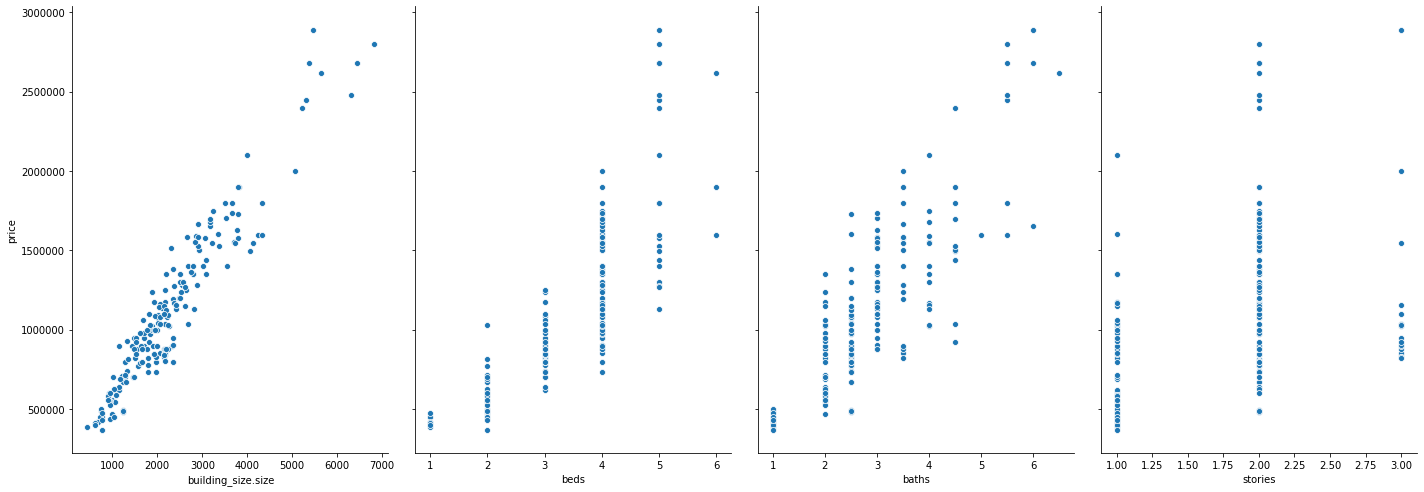

In [360]:
import seaborn as sns
sns.pairplot(data, x_vars=features_cols[:4], y_vars='price', size=7, aspect=0.7)


In [372]:
data.iloc[:,:7].corr()

,price,building_size.size,beds,baths,stories,school_rating,year_built
price,1.000000,0.954159,0.799433,0.821871,0.350076,-0.280514,0.397562
building_size.size,0.954159,1.000000,0.790917,0.847030,0.427817,-0.339301,0.412954
beds,0.799433,0.790917,1.000000,0.741374,0.396574,-0.355202,0.300495
baths,0.821871,0.847030,0.741374,1.000000,0.544320,-0.425073,0.521292
stories,0.350076,0.427817,0.396574,0.544320,1.000000,-0.437946,0.581429
school_rating,-0.280514,-0.339301,-0.355202,-0.425073,-0.437946,1.000000,-0.649694
year_built,0.397562,0.412954,0.300495,0.521292,0.581429,-0.649694,1.000000


In [350]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[features_cols], data['price'], train_size= 0.7, random_state=42)

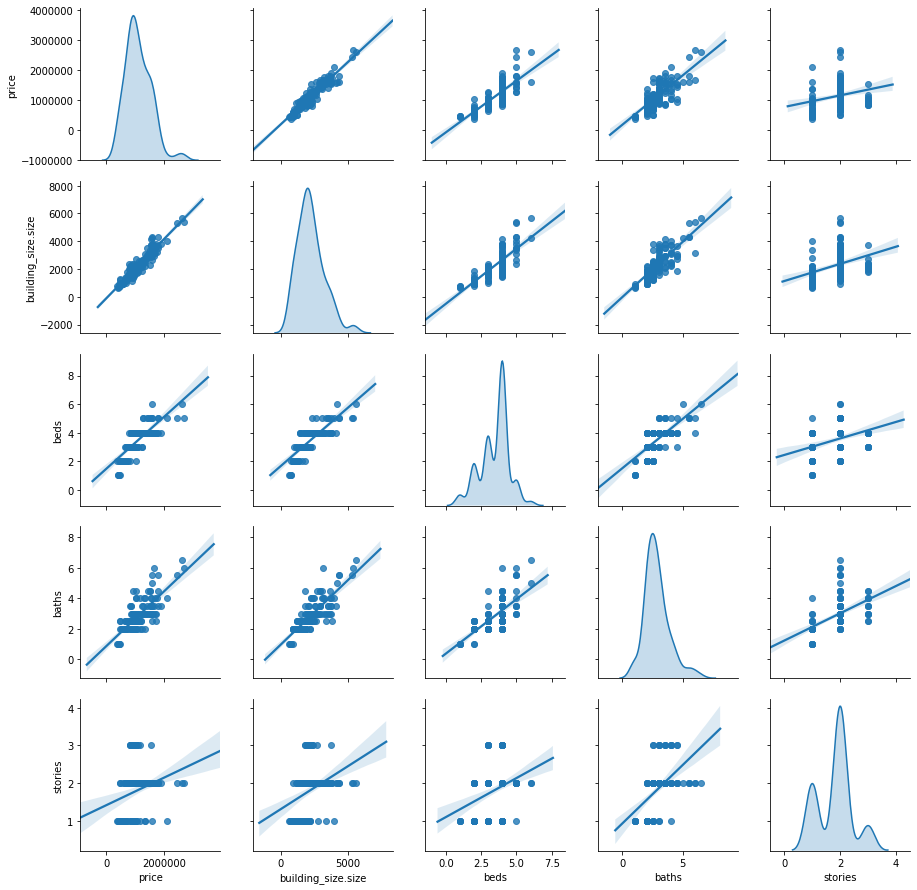

In [352]:
train_dataset = X_train[features_cols[:4]].copy()
train_dataset.insert(0, "price", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

#### Selecting the right combination of features

Several variables are correlated among them. I wan to avoid colinearity in to get meaningful coeficients, and at the same time, I want to have an accurate model. 
To determine the best set of features I will rum several combinations of features, and compare them based on RMSE and R2. 


|model 1|model 2|model 3|model 4|model 5|
|---|---|---|---|---|
|'building_size.size'|'building_size.size'|'building_size.size',|'building_size.size',|'building_size.size',| 
| 'beds'| 'beds'| 'beds'| 'beds'| 'beds'|
|'baths'|'baths'|'baths'|'baths'|'baths'|
|'stories'|'stories'|'stories'|'stories'|'stories'|
|'school_rating'||'school_rating'|'school_rating'|'school_rating'|
|'year_built'||'year_built'|'year_built'|'year_built'|
|'Arts & Entertainment'|||||
|'Food'||||
|'Outdoors & Recreation'||||
|'Professional & Other Places'||||
|'Shop & Service'||||
|'Travel & Transport'||||
|'zip_94583'|||'zip_94583'|'zip_94583'|
|'zip_94588'|||'zip_94588'|'zip_94588'|
|'nbh_Canyon Lakes South'||||'nbh_Canyon Lakes South'|
|'nbh_Crow Canyon'||||'nbh_Crow Canyon'|
|'nbh_Dougherty Hills'||||'nbh_Dougherty Hills'|
|'nbh_Dougherty Valley'||||'nbh_Dougherty Valley'|
|'nbh_Norris Canyon Estates'||||'nbh_Norris Canyon Estates'|
|'nbh_Royal Vista'||||'nbh_Royal Vista'|
|'nbh_Southern San Ramon'||||'nbh_Southern San Ramon'|
|'nbh_Twin Creeks'||||'nbh_Twin Creeks'|
|'nbh_Westside'||||'nbh_Westside'|
|'nbh_Windemere'||||'nbh_Windemere'|

In [431]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a regression object and Train the model using the training sets
cols_1 = features_cols
reg_1 = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
price_pred_1 = reg_1.predict(X_test)

# The mean squared error
print('Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, price_pred_1)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,price_pred_1))

Root Mean squared error: 141585.14
Coefficient of determination: 0.94


In [430]:
# Create a regression object and Train the model using the training sets
cols_2 = features_cols[0:4]
reg_2 = LinearRegression().fit(X_train[features_cols[:4]], y_train)

# Make predictions using the testing set
price_pred_2 = reg_2.predict(X_test[features_cols[:4]])

# The mean squared error
print('Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, price_pred_2)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,price_pred_2))

Root Mean squared error: 144006.62
Coefficient of determination: 0.94


In [416]:
# Create a regression object and Train the model using the training sets
cols_3 = features_cols[0:6]
reg_3 = LinearRegression().fit(X_train[cols_3], y_train)

# Make predictions using the testing set
price_pred_3 = reg_3.predict(X_test[cols_3])

# The mean squared error
print('Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, price_pred_3)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,price_pred_3))

Root Mean squared error: 134401.16
Coefficient of determination: 0.95


In [413]:
# Create a regression object and Train the model using the training sets
cols_4= features_cols[0:6]+features_cols[12:14]
reg_4 = LinearRegression().fit(X_train[cols_4], y_train)

# Make predictions using the testing set
price_pred_4 = reg_4.predict(X_test[cols_4])

# The mean squared error
print('Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, price_pred_4)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,price_pred_4))

Root Mean squared error: 133315.09
Coefficient of determination: 0.95


In [414]:
# Create a regression object and Train the model using the training sets
cols_5= features_cols[0:6]+features_cols[12:]
reg_5 = LinearRegression().fit(X_train[cols_5], y_train)

# Make predictions using the testing set
price_pred_5 = reg_5.predict(X_test[cols_5])

# The mean squared error
print('Root Mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y_test, price_pred_5)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test,price_pred_5))

Root Mean squared error: 137881.29
Coefficient of determination: 0.95


#### Comparison of Performance for the different models

From the 5 sets of features used to solve this problem, model 4 was the one with smalles Root Mean Squared Error. 
The graph below shows the comparison between models. 


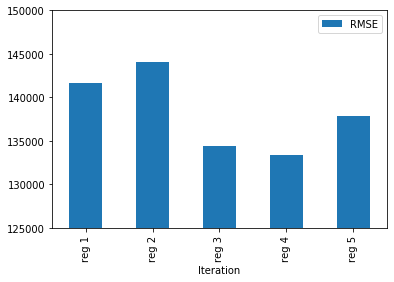

In [423]:
RMSE = {'Iteration': ['reg 1','reg 2','reg 3','reg 4','reg 5'],
        'RMSE':[np.sqrt(mean_squared_error(y_test, price_pred_1)),
        np.sqrt(mean_squared_error(y_test, price_pred_2)),
        np.sqrt(mean_squared_error(y_test, price_pred_3)),
        np.sqrt(mean_squared_error(y_test, price_pred_4)),
        np.sqrt(mean_squared_error(y_test, price_pred_5))
       ]}       
pd.DataFrame(RMSE).plot.bar(x='Iteration',y='RMSE',ylim=(125000,150000))

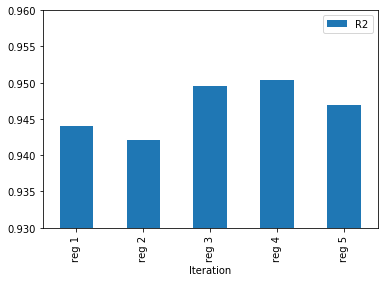

In [537]:
R2 = {'Iteration': ['reg 1','reg 2','reg 3','reg 4','reg 5'],
      'R2':[r2_score(y_test, price_pred_1),
              r2_score(y_test, price_pred_2),
              r2_score(y_test, price_pred_3),
              r2_score(y_test, price_pred_4),
              r2_score(y_test, price_pred_5)
       ]}       
pd.DataFrame(R2).plot.bar(x='Iteration',y='R2',ylim=(0.93,.96))

#### The winning model's coeficients 

From the 5 sets of features used to solve this problem, model 4 was the one with smalles Root Mean Squared Error. 
The graph below shows the comparison between models.

The winning combination contains:
* Built Surface
* Number of Bedrooms
* Number of Baths
* School ratings
* Year Built
* Postal code

In [424]:
pd.DataFrame(reg_4.coef_,index=data[cols_4].columns, columns=['Coeficient'])

,Coeficient
building_size.size,363.142507
beds,61082.726749
baths,17371.953626
stories,-95848.255351
school_rating,91867.688896
year_built,3824.983023
zip_94583,17282.230079
zip_94588,272997.346664


In [503]:
def price_gain(prop_base, increment):
    price1 = reg_4.predict((prop_base + increment).reshape(1,-1))[0]
    price2 = reg_4.predict(prop_base.reshape(1,-1))[0]
    print('The property gains ${:,.2f} in value for adding \n{} sqft\n{} bedrooms,\n{} bathrooms, and\n{} floors.'.format(price1-price2,increment[0], increment[1],increment[2], increment[3]))
    print('Original estimated price: ${:,.2f}\nNew estimated price:    ${:,.2f}'.format(price1,price2))
    return price1-price2


In [504]:
price_gain(data.loc[100,cols_4].values,
           [100,1,1,0,0,0,0,0]
           )

The property gains $114,768.93 in value for adding 
100 sqft
1 bedrooms,
1 bathrooms, and
0 floors.
Original estimated price: $1,056,036.28
New estimated price:    $941,267.35


114768.93102911115

## 4.Results <a name="results"></a>

https://www.homeadvisor.com/cost/bathrooms/#half


The evaluation of the added value to the property can be done by using reference data for the costs and typical sizes of the expansions done to a typical house. 

#### Bath room:
* Area = 40 sqft
* Average cost to convert an existing space = \$5,000
* Average cost to build an new space = \$22,000 

First let's evaluate a bathroom that is added to the house, adding squared feet to the house.

In [548]:
gain_bath = price_gain(data.loc[100,cols_4].values,
           [40,0,1,0,0,0,0,0]
           )

The property gains $31,897.65 in value for adding 
40 sqft
0 bedrooms,
1 bathrooms, and
0 floors.
Original estimated price: $973,165.00
New estimated price:    $941,267.35


In [549]:
cost_bath = 22000
ROI_bath = gain_bath/cost_bath
print('Consideing a cost of {}, the ROI of the investment would be {:.2%}'.format(cost_bath,ROI_bath))

Consideing a cost of 22000, the ROI of the investment would be 144.99%


Now let's see what happens if the new bathroom is built reusing space in the house. 

In [551]:
gain_bath = price_gain(data.loc[100,cols_4].values,
           [0,0,1,0,0,0,0,0]
           )

The property gains $17,371.95 in value for adding 
0 sqft
0 bedrooms,
1 bathrooms, and
0 floors.
Original estimated price: $958,639.30
New estimated price:    $941,267.35


In [553]:
cost_bath = 17000
ROI_bath = gain_bath/cost_bath
print('Consideing a cost of {}, the ROI of the investment would be {:.2%}'.format(cost_bath,ROI_bath))

Consideing a cost of 17000, the ROI of the investment would be 102.19%


#### Half bathroom:
* Area = 25 sqft
* Average cost = \$20,000


In [519]:
gain_half= price_gain(data.loc[100,cols_4].values,
           [25,0,.5,0,0,0,0,0]
           )

The property gains $17,764.54 in value for adding 
25 sqft
0 bedrooms,
0.5 bathrooms, and
0 floors.
Original estimated price: $959,031.89
New estimated price:    $941,267.35


In [520]:
cost_half = 20000
ROI_half = gain_half/cost_half
print('Consideing a cost of {}, the ROI of the investment would be {:.2%}'.format(cost_half,ROI_half))

Consideing a cost of 20000, the ROI of the investment would be 88.82%


#### Second Floor:
* Cost = from \\$100,000 to \\$150,000
* Area = from 600 sqft to 1500 sqft

In [525]:
gain_floor= price_gain(data.loc[100,cols_4].values,
           [700,2,1,1,0,0,0,0]
           )

The property gains $297,888.91 in value for adding 
700 sqft
2 bedrooms,
1 bathrooms, and
1 floors.
Original estimated price: $1,239,156.26
New estimated price:    $941,267.35


In [526]:
cost_floor = 110000
ROI_floor = gain_floor/cost_floor
print('Consideing a cost of {}, the ROI of the investment would be {:.2%}'.format(cost_floor,ROI_floor))

Consideing a cost of 110000, the ROI of the investment would be 270.81%


#### Adding a new room:
* Area = 200 sqft to 600 sqft
* Cost = \$ 45,000 average (from 10k to 125k)

In [531]:
gain_room= price_gain(data.loc[100,cols_4].values,
           [400,1,0,0,0,0,0,0]
           )

The property gains $206,339.73 in value for adding 
400 sqft
1 bedrooms,
0 bathrooms, and
0 floors.
Original estimated price: $1,147,607.08
New estimated price:    $941,267.35


In [532]:
cost_room = 60000
ROI_room = gain_room/cost_room
print('Consideing a cost of {}, the ROI of the investment would be {:.2%}'.format(cost_room,ROI_room))

Consideing a cost of 60000, the ROI of the investment would be 343.90%


## 5. Discussion<a name="discussion"></a>

### 5.1 Data Issues

Here are the consideration I made to eliminate or replace null values in the data:

* **Lot Size** : Too many NA values to be used. This was the case for the lot size, that presented >30% of missing data. 
* **Year Built**: In theory the year of construction of the house is relevant to determine the qualiy of the construction, and might be related to price. That field had 8% of empty values. The most likely   
* **School Rating** The missing value in School rating was due to a failure in the API call for the details. I just repeated the call and fixed it manually.
* **County** Not used. Already contained in zipcode. 

### 5.2 Modeing Issues

* **Interactions between variables**: this model considers the variables as independent. Clearly there is a correlation between bath, rooms, and quared feet that are condider in the evaluation of the options. For example, when the house gets a new room, the evaluation considers the increase in the number of rooms and also the increase in the built surface. The interaction that is not captured here is the interaction between zip_codes and the other variables. Clearle a squared meter in one zip code is more valuable than in other. Introduce this interaction would require to include combined varibales such as zip x baths and zip x surface. 



## 6. Conclusion <a name="conclusion"></a>

The listing price of houses depend strongly on the charateristics of the house itself, the postal_code, the rating of schools, but surprisingly not as strongly on the services surrounding them, the concentration of shops, or the closeness to recreation locations.

Other variables that showed up as weak was the neighborhood, or al least less informative that the zip_code. That doesn no't mean necesarily that it is not important but simply correlated to a other more relevant variable. 

Another finding was that not all real state investemnt produces postive returs. Here the examples of the half bathroom is clearly returning less that the investment needed, and the bathroom built reusing space in the house barely makes the cut. 
Analyzing the coeficients we can see that many other combinations give negative retunrs, for example adding a second floor is not worth it unless you add enough surface and rooms to the building.  

Clearly, investment in Real Estate depends strongly on the cost of labor, the additioal built surface added, and the rooms added.  